<a href="https://colab.research.google.com/github/Alaa-c/MachineLearningProj/blob/main/headPose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mediapipe

In [68]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn import svm
import xgboost as xgb
from sklearn.model_selection import GridSearchCV #optimze parameters
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.metrics import mean_squared_error as mse

In [ ]:
def get_list_from_filenames(file_path):
  lines=[Path(f).stem for f in glob.glob(file_path)]
  return lines

In [ ]:
def get_ypr_from_mat(mat_path):#get yaw,pitch,roll in radians
  mat=sio.loadmat(mat_path)
  pre_pose_params=mat['Pose_Para'][0]
  #get ypr
  pose_params=pre_pose_params[:3]
  return pose_params
    

In [ ]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

In [ ]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

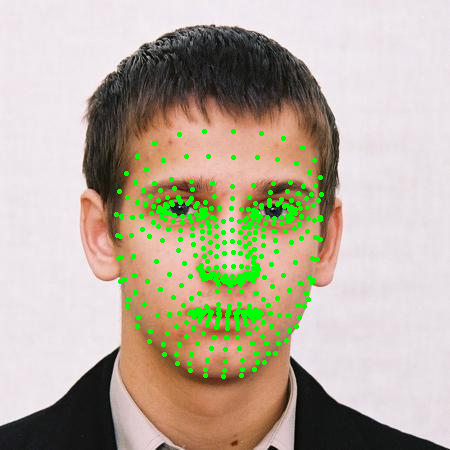

In [ ]:
# choosing random image
random_file = 'image00053'
ltest=[]
lfeatures=[]
faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              lfeatures.append(relative_x)
              lfeatures.append(relative_y)
      
              
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
      cv2_imshow(image)
      ltest.append(lfeatures)
      

dict_keys(['__header__', '__version__', '__globals__', 'pt2d', 'Illum_Para', 'Color_Para', 'Tex_Para', 'Shape_Para', 'Exp_Para', 'Pose_Para', 'roi', 'pt3d_68'])


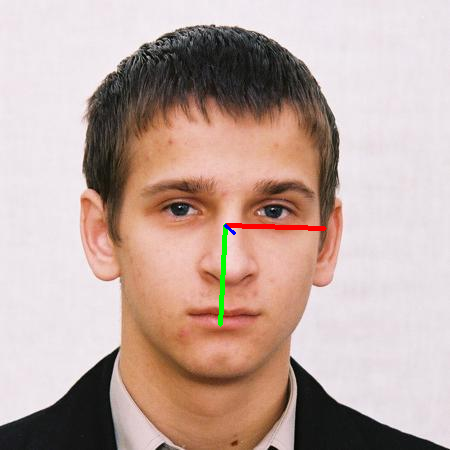

In [ ]:
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
print(mat_file.keys())
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll))

In [ ]:
def dataset_images_operations(imj_path):
    
    faceModule = mediapipe.solutions.face_mesh
    listxy=[]
    labels=[]
    c=0
    for imj in os.listdir(imj_path):
      
      if (imj.endswith('.jpg')):
        #print(c)
        # loading image and its correspinding mat file
        with faceModule.FaceMesh(static_image_mode=True) as faces:
        # loading the image
          image = cv2.imread('/content/AFLW2000/'+imj)
          # processing the face to extract the landmark points (468 point) for each x,y,z
          results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
          lfeatures=[]
          ylabels=[]
          if results.multi_face_landmarks != None: 
            # looping over the faces in the image
            for face in results.multi_face_landmarks:
                for landmark in face.landmark:
                    x = landmark.x
                    y = landmark.y
                    
                    # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                    shape = image.shape 
                    relative_x = int(x * shape[1])
                    relative_y = int(y * shape[0])
                    lfeatures.append(relative_x)
                    lfeatures.append(relative_y)
                    cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
            #cv2_imshow(image)
            listxy.append(lfeatures)
            mat_file = sio.loadmat('/content/AFLW2000/'+imj.split('.')[0]+'.mat')
            # extracting the labels 3 angels
            pose_para = mat_file["Pose_Para"][0][:3]
            pitch = pose_para[0]
            yaw = pose_para[1]
            roll = pose_para[2]
            ylabels.append(pitch)
            ylabels.append(yaw)
            ylabels.append(roll)
            #print(ylabels)
            labels.append(ylabels)
            #cv2_imshow(draw_axis(image,pitch,yaw,roll))
    return listxy,labels


**Convert points and labels to dataframe**

In [ ]:
path="/content/AFLW2000/"
listxy,labels=dataset_images_operations(path)


In [ ]:
df1=pd.DataFrame(labels)
df=pd.DataFrame(listxy)
df1.rename(columns={0:'pitch',1:'yaw',2:'roll'},inplace=True)
df3=pd.concat([df,df1],axis=1)
df3

0    1    2    3    4    5    6    7    8    9  ...  929  930  931  \
0     223  304  220  272  222  283  213  242  220  262  ...  222  237  223   
1     208  316  189  291  207  296  190  260  186  283  ...  226  225  230   
2     231  315  228  291  229  296  217  255  227  281  ...  217  239  221   
3     203  293  198  270  207  278  205  246  199  263  ...  235  236  236   
4     193  276  210  245  209  261  229  224  216  237  ...  240  267  237   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1848  195  290  198  255  205  270  210  227  201  246  ...  223  252  222   
1849  229  299  218  278  224  284  210  254  216  271  ...  231  230  233   
1850  230  298  245  281  234  284  238  257  247  275  ...  232  244  235   
1851  194  281  199  254  202  266  208  233  201  246  ...  230  241  229   
1852  255  284  260  248  252  265  242  225  259  239  ...  217  251  217   

      932  933  934  935     pitch       yaw      roll  
0     291  211  295  208  0.075391  0.066288 -0.076080  
1     280  214  286  205 -0.514121  0.752342 -0.341487  
2     295  197  299  193 -0.347319 -0.027759 -0.091287  
3     282  241  287  239 -0.029032  0.567679  0.240908  
4     316  271  324  272  0.442086  0.223025  0.786156  
...   ...  ...  ...  ...       ...       ...       ...  
1848  312  236  320  234  0.210636  0.667445  0.484012  
1849  272  218  275  214 -0.119610  0.249940 -0.192510  
1850  269  224  272  220 -0.537956 -0.478792  0.254959  
1851  287  240  294  238  0.282187  0.604873  0.474036  
1852  289  216  293  212  0.386240 -0.328510 -0.109401  

[1853 rows x 939 columns]

**Transform the points to be relative to the nose point**

In [ ]:
def centeralize_imj(df4):
    df4.iloc[:,0::2]=df4.iloc[:,0::2].sub(df4[2],axis=0)
    df4.iloc[:,1::2]=df4.iloc[:,1::2].sub(df4[3],axis=0)
    return df4


In [ ]:
df4=df3.copy()
df4=df4.drop(columns=['pitch','yaw','roll'],axis=1)
df4=centeralize_imj(df4)
df4

0    1    2    3    4    5    6    7    8    9    ...  926  927  928  \
0       3   32    0    0    2   11   -7  -30    0  -10  ...   26  -52   21   
1      19   25    0    0   18    5    1  -31   -3   -8  ...   48  -70   42   
2       3   24    0    0    1    5  -11  -36   -1  -10  ...   19  -78   14   
3       5   23    0    0    9    8    7  -24    1   -7  ...   48  -36   43   
4     -17   31    0    0   -1   16   19  -21    6   -8  ...   68   -2   62   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1848   -3   35    0    0    7   15   12  -28    3   -9  ...   66  -32   59   
1849   11   21    0    0    6    6   -8  -24   -2   -7  ...   19  -49   15   
1850  -15   17    0    0  -11    3   -7  -24    2   -6  ...    0  -52   -1   
1851   -5   27    0    0    3   12    9  -21    2   -8  ...   51  -24   46   
1852   -5   36    0    0   -8   17  -18  -23   -1   -9  ...   -6  -32   -9   

      929  930  931  932  933  934  935  
0     -50   17  -49   71  -61   75  -64  
1     -65   36  -61   91  -77   97  -86  
2     -74   11  -70   67  -94   71  -98  
3     -35   38  -34   84  -29   89  -31  
4      -5   57   -8  106   26  114   27  
...   ...  ...  ...  ...  ...  ...  ...  
1848  -32   54  -33  114  -19  122  -21  
1849  -47   12  -45   54  -60   57  -64  
1850  -49   -1  -46   24  -57   27  -61  
1851  -24   42  -25   88  -14   95  -16  
1852  -31   -9  -31   29  -32   33  -36  

[1853 rows x 936 columns]

**Divide by euclidean distance to scale the centered points**

In [ ]:
def standarize_imj(df4):
  scale=np.sqrt((df4[8]-df4[170])**2+(df4[9]-df4[171])**2)
  df4=df4.divide(scale,axis=0)
  return df4

In [ ]:
df4=standarize_imj(df4)
df4

0         1    2    3         4         5         6         7    \
0     0.045958  0.490224  0.0  0.0  0.030639  0.168514 -0.107236 -0.459585   
1     0.365587  0.481036  0.0  0.0  0.346346  0.096207  0.019241 -0.596485   
2     0.058543  0.468343  0.0  0.0  0.019514  0.097571 -0.214657 -0.702514   
3     0.116248  0.534739  0.0  0.0  0.209246  0.185996  0.162747 -0.557989   
4    -0.232094  0.423230  0.0  0.0 -0.013653  0.218441  0.259399 -0.286704   
...        ...       ...  ...  ...       ...       ...       ...       ...   
1848 -0.042905  0.500562  0.0  0.0  0.100112  0.214527  0.171621 -0.400450   
1849  0.233673  0.446102  0.0  0.0  0.127458  0.127458 -0.169944 -0.509831   
1850 -0.301086  0.341231  0.0  0.0 -0.220796  0.060217 -0.140507 -0.481737   
1851 -0.086829  0.468874  0.0  0.0  0.052097  0.208389  0.156291 -0.364680   
1852 -0.070591  0.508254  0.0  0.0 -0.112945  0.240009 -0.254127 -0.324718   

           8         9    ...       926       927       928       929  \
0     0.000000 -0.153195  ...  0.398307 -0.796613  0.321709 -0.765974   
1    -0.057724 -0.153932  ...  0.923589 -1.346901  0.808141 -1.250694   
2    -0.019514 -0.195143  ...  0.370771 -1.522114  0.273200 -1.444057   
3     0.023250 -0.162747  ...  1.115977 -0.836983  0.999730 -0.813733   
4     0.081916 -0.109221  ...  0.928376 -0.027305  0.846461 -0.068263   
...        ...       ...  ...       ...       ...       ...       ...   
1848  0.042905 -0.128716  ...  0.943917 -0.457657  0.843805 -0.457657   
1849 -0.042486 -0.148701  ...  0.403616 -1.040905  0.318644 -0.998419   
1850  0.040145 -0.120434  ...  0.000000 -1.043764 -0.020072 -0.983547   
1851  0.034731 -0.138926  ...  0.885652 -0.416777  0.798823 -0.416777   
1852 -0.014118 -0.127063  ... -0.084709 -0.451781 -0.127063 -0.437663   

           930       931       932       933       934       935  
0     0.260431 -0.750655  1.087684 -0.934489  1.148962 -0.980447  
1     0.692692 -1.173728  1.750972 -1.481591  1.866420 -1.654764  
2     0.214657 -1.366000  1.307457 -1.834343  1.385514 -1.912400  
3     0.883482 -0.790484  1.952960 -0.674236  2.069208 -0.720735  
4     0.778198 -0.109221  1.447175  0.354967  1.556396  0.368620  
...        ...       ...       ...       ...       ...       ...  
1848  0.772296 -0.471959  1.630403 -0.271734  1.744817 -0.300337  
1849  0.254916 -0.955933  1.147120 -1.274578  1.210849 -1.359550  
1850 -0.020072 -0.923330  0.481737 -1.144126  0.541955 -1.224416  
1851  0.729360 -0.434143  1.528183 -0.243120  1.649743 -0.277851  
1852 -0.127063 -0.437663  0.409426 -0.451781  0.465899 -0.508254  

[1853 rows x 936 columns]

In [ ]:
x=df4
y=df1
y


pitch       yaw      roll
0     0.075391  0.066288 -0.076080
1    -0.514121  0.752342 -0.341487
2    -0.347319 -0.027759 -0.091287
3    -0.029032  0.567679  0.240908
4     0.442086  0.223025  0.786156
...        ...       ...       ...
1848  0.210636  0.667445  0.484012
1849 -0.119610  0.249940 -0.192510
1850 -0.537956 -0.478792  0.254959
1851  0.282187  0.604873  0.474036
1852  0.386240 -0.328510 -0.109401

[1853 rows x 3 columns]

split data into training and testing

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
y_test

pitch       yaw      roll
303  -0.269785 -0.679571  0.139078
1242  0.103059 -0.152956 -0.421933
1810 -0.217868 -0.541534  0.027177
1687 -0.243402  0.089782 -0.030902
1009 -0.138380  0.087130  0.405625
...        ...       ...       ...
214  -0.297233  0.141253 -0.040865
1084  0.036745  0.218198  0.209357
1592  0.015491 -0.000895 -0.048069
335  -0.007654 -0.084222 -0.049241
1773  0.035011 -0.224987 -0.228517

[371 rows x 3 columns]

Train the model to predict pitch

using svr

In [69]:
pitch_sv=svm.SVR()
pitch_sv.fit(x_train,y_train['pitch'])


SVR()

test the model

In [70]:
pitch_sv.score(x_test,y_test['pitch'])
yp_test=pitch_sv.predict(x_test)
print('mse in pitch using svr=',mse(y_test['pitch'],yp_test))

print('r2 in pitch using svr=',pitch_sv.score(x_test,y_test['pitch']))

mse in pitch using svr= 0.04241258498580455
r2 in pitch using svr= 0.5733290589741324


using random forest

In [ ]:
randf=rf()
randf.fit(x_train,y_train['pitch'])
yp_test=randf.predict(x_test)
print('mse in pitch using randomforest=',mse(y_test['pitch'],yp_test))
print('r2 in pitch using rf=',randf.score(x_test,y_test['pitch']))

Train the model to predict yaw

In [71]:
#yaw_xg=xgb.XGBRegressor()
yaw_sv=svm.SVR()
param={'n_estimators':[15,50,100],
       'max_depth':[5,10,20],
       'learning_rate':[0.001,0.1,0.01]   
}
yaw_sv.fit(x_train,y_train['yaw'])


SVR()

test the model

In [72]:


yp_test=yaw_sv.predict(x_test)
print('mse in yaw using xgboost=',mse(y_test['yaw'],yp_test))
print('r2 in yaw using xgboost=',yaw_sv.score(x_test,y_test['yaw']))


mse in yaw using xgboost= 0.036846177582737685
r2 in yaw using xgboost= 0.8892628271904671


Train the model to predict roll

using xgboost

In [ ]:
xg2=xgb.XGBRegressor()
param={'n_estimators':[15,50,100],
       'max_depth':[5,10,20],
       'learning_rate':[0.001,0.1,0.01]   
}
xg2.fit(x_train,y_train['roll'])

[22:43:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

Test the model

In [ ]:

yp_test=xg2.predict(x_test)
print('mse in roll using xgboost=',mse(y_test['roll'],yp_test))
print('r2 in roll using xgboost=',xg2.score(x_test,y_test['roll']))

mse in roll using xgboost= 0.08819231170647761
r2 in roll using xgboost= 0.42362606153972127


use svr

In [73]:
roll_sv=svm.SVR()
roll_sv.fit(x_train,y_train['roll'])

yp_test=roll_sv.predict(x_test)
print('mse in roll using svr=',mse(y_test['roll'],yp_test))
print('r2 in roll using svr=',roll_sv.score(x_test,y_test['roll']))


mse in roll using svr= 0.06527668960745862
r2 in roll using svr= 0.573389313073912


Test on a video

In [ ]:
def video_reading(video_path):
  videocap=cv2.VideoCapture(video_path)
  success,image=videocap.read()
  count=0
  while success:
    cv2.imwrite("/content/sample_data/Fr/frame%d.jpg"%count,image)
    success,image=videocap.read()
    print("read a new frame:",success)
    count+=1


In [ ]:
video_reading("/content/sample_data/henedy.mp4.mp4")

read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new frame: True
read a new 

In [ ]:
def process_video_frames(path):

    faceModule = mediapipe.solutions.face_mesh
    df=[]
    labels=[]
    c=0
    for imj in os.listdir(path):
      
      if (imj.endswith('.jpg')):
        #print(c)
        # loading image and its correspinding mat file
        with faceModule.FaceMesh(static_image_mode=True) as faces:
        # loading the image
          image = cv2.imread('/content/sample_data/Fr/'+imj)
          # processing the face to extract the landmark points (468 point) for each x,y,z
          results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
          lfeatures=[]
          
          if results.multi_face_landmarks != None: 
            # looping over the faces in the image
            for face in results.multi_face_landmarks:
                for landmark in face.landmark:
                    x = landmark.x
                    y = landmark.y
                    
                    # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                    shape = image.shape 
                    relative_x = int(x * shape[1])
                    relative_y = int(y * shape[0])
                    lfeatures.append(relative_x)
                    lfeatures.append(relative_y)
                    cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
            #cv2_imshow(image
            df.append(lfeatures)
            
            
           
    return df

Transform frames

In [ ]:
df_video=process_video_frames('/content/sample_data/Fr')
video_df=pd.DataFrame(df_video)
originx=video_df[2]
originy=video_df[3]
video_df

0    1     2    3     4    5     6    7     8    9    ...   926  927  \
0     835  610   834  526   827  554   799  456   832  503  ...   855  397   
1    1457  514  1449  441  1457  460  1436  360  1448  417  ...  1525  294   
2    1460  503  1452  430  1460  450  1437  350  1451  407  ...  1524  284   
3    1172  676  1243  640  1189  644  1238  571  1256  624  ...  1233  527   
4    1133  664  1205  623  1152  630  1197  555  1217  607  ...  1197  516   
..    ...  ...   ...  ...   ...  ...   ...  ...   ...  ...  ...   ...  ...   
114  1472  529  1464  455  1472  476  1452  374  1463  431  ...  1540  309   
115   615  659   578  613   602  623   564  533   574  591  ...   671  456   
116   812  352   809  276   799  319   766  238   805  255  ...   789  225   
117   798  321   795  248   788  290   761  223   792  232  ...   795  230   
118   579  622   519  567   541  583   466  534   505  553  ...   500  438   

      928  929   930  931   932  933   934  935  
0     844  402   840  405   961  378   971  364  
1    1511  301  1503  306  1629  294  1643  284  
2    1511  291  1503  297  1628  283  1642  274  
3    1231  530  1235  535  1269  547  1274  540  
4    1194  519  1198  524  1235  541  1243  533  
..    ...  ...   ...  ...   ...  ...   ...  ...  
114  1527  316  1519  321  1642  309  1656  300  
115   655  463   644  470   791  439   805  429  
116   783  227   782  225   857  217   863  209  
117   787  229   785  225   863  231   870  222  
118   493  452   489  460   573  357   575  341  

[119 rows x 936 columns]

In [ ]:
vdf1=centeralize_imj(video_df)
video_test=standarize_imj(vdf1)
video_test

0         1    2    3         4         5         6         7    \
0    0.006445  0.541350  0.0  0.0 -0.045112  0.180450 -0.225562 -0.451125   
1    0.057715  0.526654  0.0  0.0  0.057715  0.137074 -0.093788 -0.584369   
2    0.056934  0.519524  0.0  0.0  0.056934  0.142335 -0.106751 -0.569341   
3   -0.405880  0.205798  0.0  0.0 -0.308697  0.022866 -0.028583 -0.394447   
4   -0.410385  0.233691  0.0  0.0 -0.302089  0.039899 -0.045598 -0.387586   
..        ...       ...  ...  ...       ...       ...       ...       ...   
114  0.057304  0.530061  0.0  0.0  0.057304  0.150423 -0.085956 -0.580202   
115  0.294310  0.365898  0.0  0.0  0.190904  0.079543 -0.111360 -0.636345   
116  0.016298  0.412891  0.0  0.0 -0.054328  0.233609 -0.233609 -0.206446   
117  0.018706  0.455176  0.0  0.0 -0.043647  0.261882 -0.212000 -0.155882   
118  0.409263  0.375158  0.0  0.0  0.150063  0.109137 -0.361516 -0.225095   

          8         9    ...       926       927       928       929  \
0   -0.012889 -0.148227  ...  0.135337 -0.831359  0.064446 -0.799136   
1   -0.007214 -0.173146  ...  0.548297 -1.060522  0.447295 -1.010021   
2   -0.007117 -0.163686  ...  0.512407 -1.039047  0.419889 -0.989230   
3    0.074316 -0.091466  ... -0.057166 -0.645978 -0.068599 -0.628828   
4    0.068397 -0.091197  ... -0.045598 -0.609877 -0.062698 -0.592778   
..        ...       ...  ...       ...       ...       ...       ...   
114 -0.007163 -0.171912  ...  0.544387 -1.045796  0.451268 -0.995655   
115 -0.031817 -0.174995  ...  0.739751 -1.248827  0.612482 -1.193147   
116 -0.021731 -0.114088  ... -0.108656 -0.277072 -0.141252 -0.266206   
117 -0.018706 -0.099765  ...  0.000000 -0.112235 -0.049882 -0.118470   
118 -0.095495 -0.095495  ... -0.129600 -0.879916 -0.177347 -0.784421   

          930       931       932       933       934       935  
0    0.038668 -0.779802  0.818470 -0.953807  0.882916 -1.044032  
1    0.389580 -0.973949  1.298599 -1.060522  1.399601 -1.132667  
2    0.362955 -0.946529  1.252550 -1.046164  1.352185 -1.110215  
3   -0.045733 -0.600245  0.148632 -0.531646  0.177215 -0.571662  
4   -0.039899 -0.564279  0.170994 -0.467383  0.216592 -0.512981  
..        ...       ...       ...       ...       ...       ...  
114  0.393964 -0.959840  1.275011 -1.045796  1.375293 -1.110263  
115  0.524985 -1.137467  1.694269 -1.384051  1.805629 -1.463594  
116 -0.146685 -0.277072  0.260773 -0.320534  0.293370 -0.363996  
117 -0.062353 -0.143411  0.423999 -0.106000  0.467646 -0.162117  
118 -0.204632 -0.729853  0.368337 -1.432421  0.381979 -1.541558  

[119 rows x 936 columns]

**predict pitch,yaw,roll for video frames**

In [ ]:
ypred=[]
vpitch=pitch_sv.predict(video_test)
vyaw=yaw_sv.predict(video_test)
vroll=roll_sv.predict(video_test)
originx



0       834
1      1449
2      1452
3      1243
4      1205
       ... 
114    1464
115     578
116     809
117     795
118     519
Name: 2, Length: 119, dtype: int64

draw axes on images in video

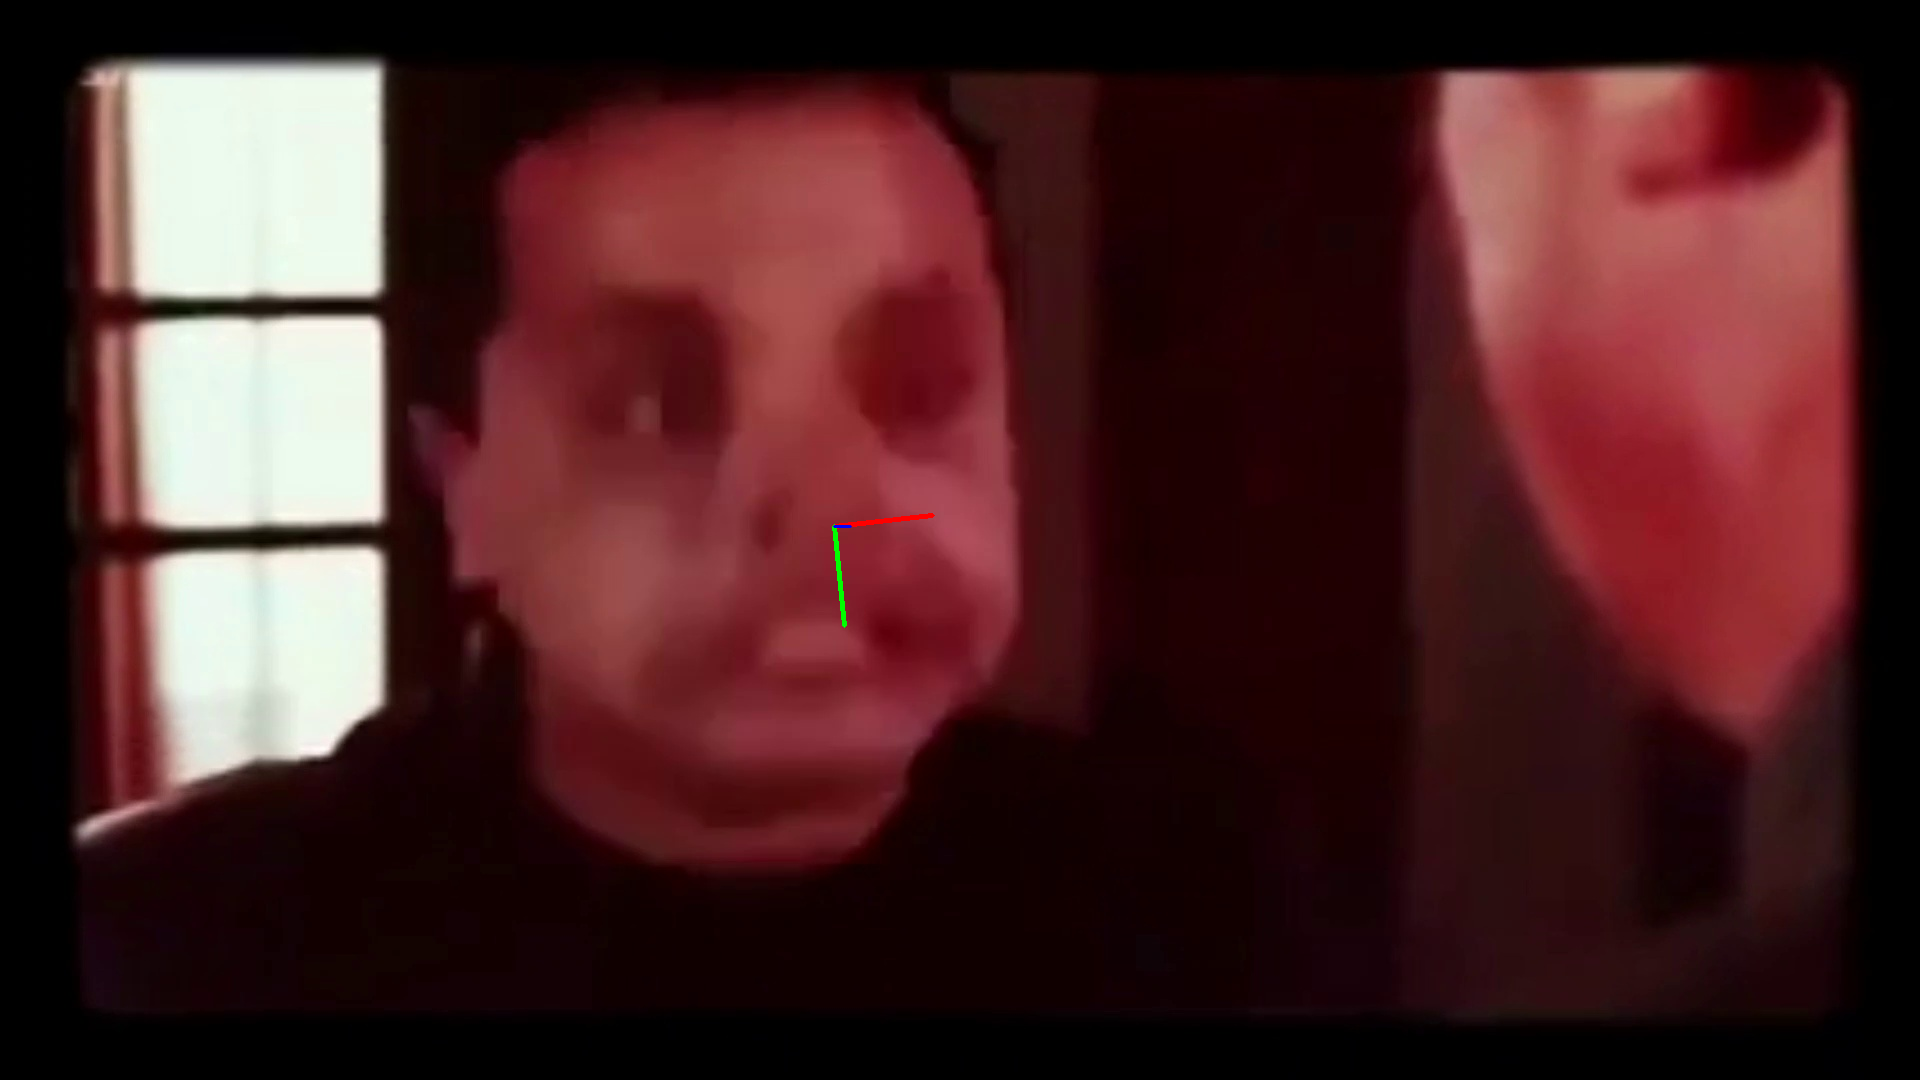

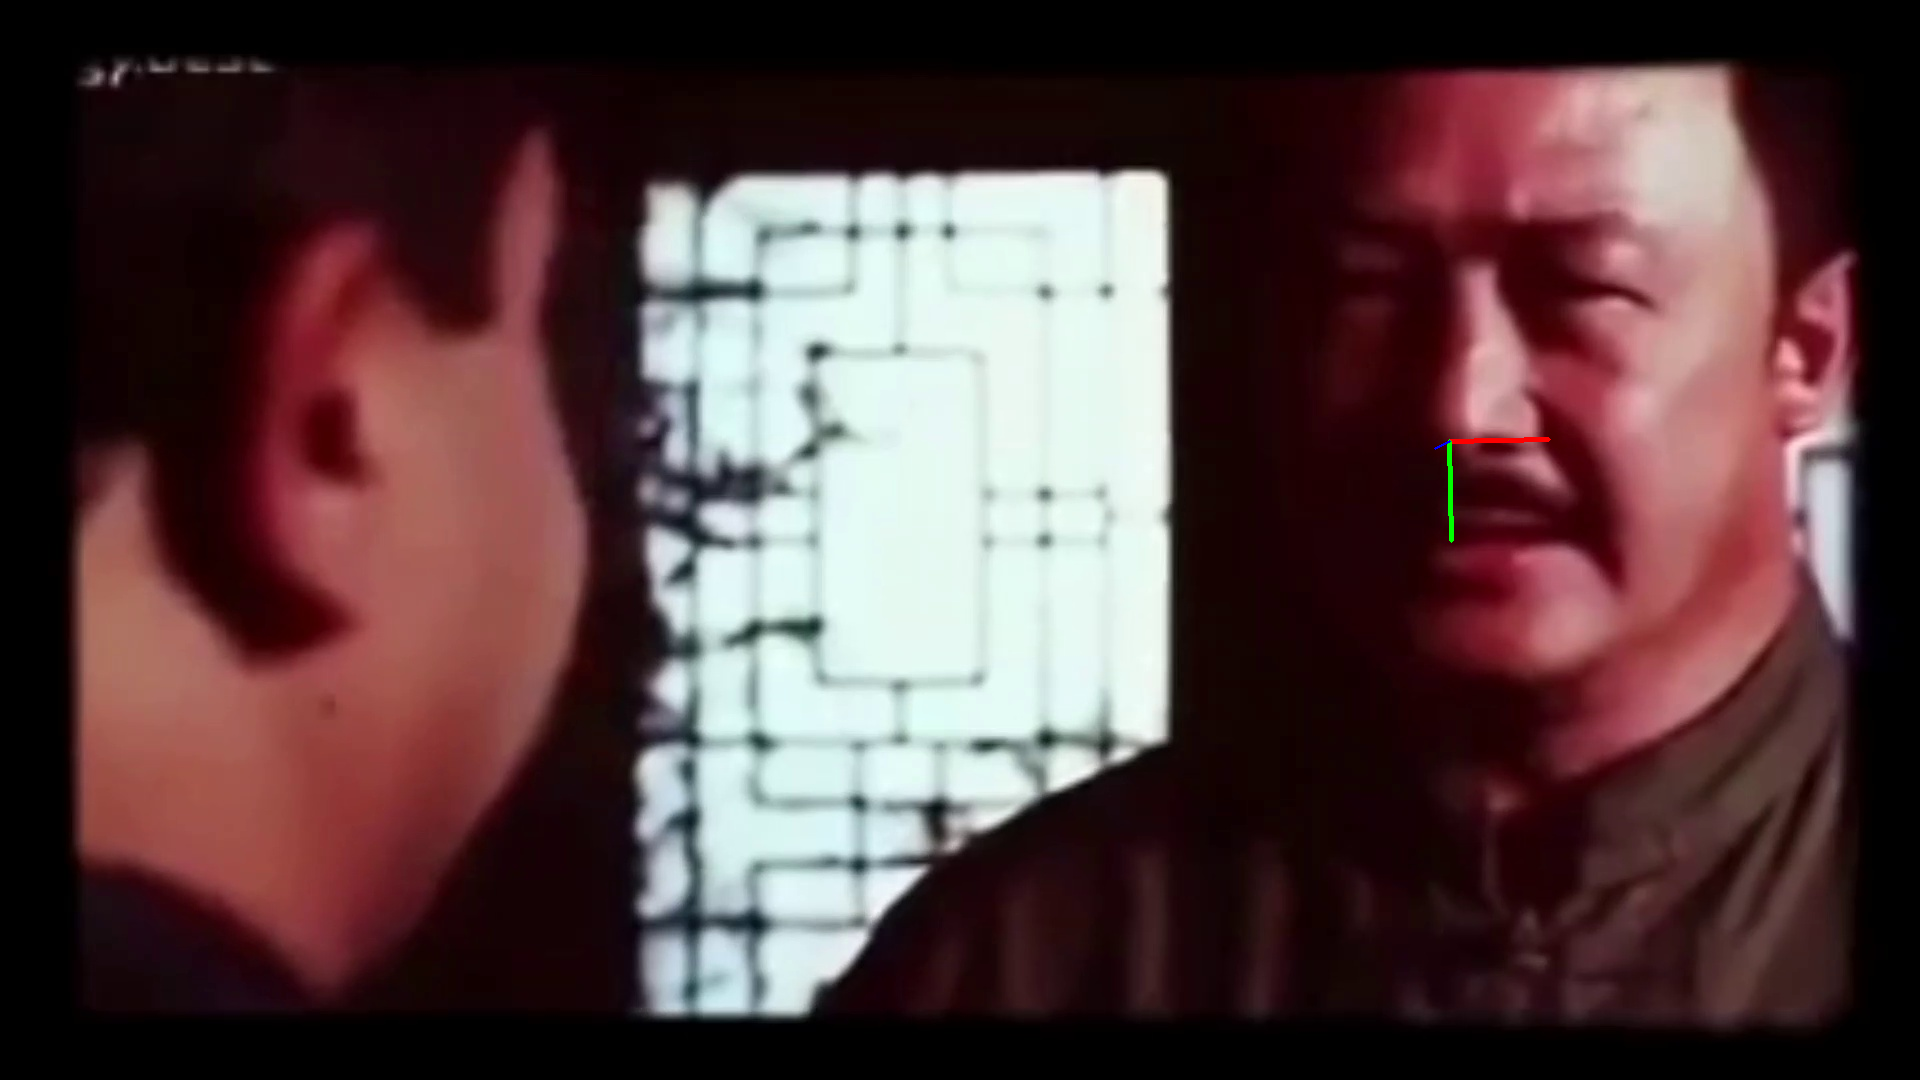

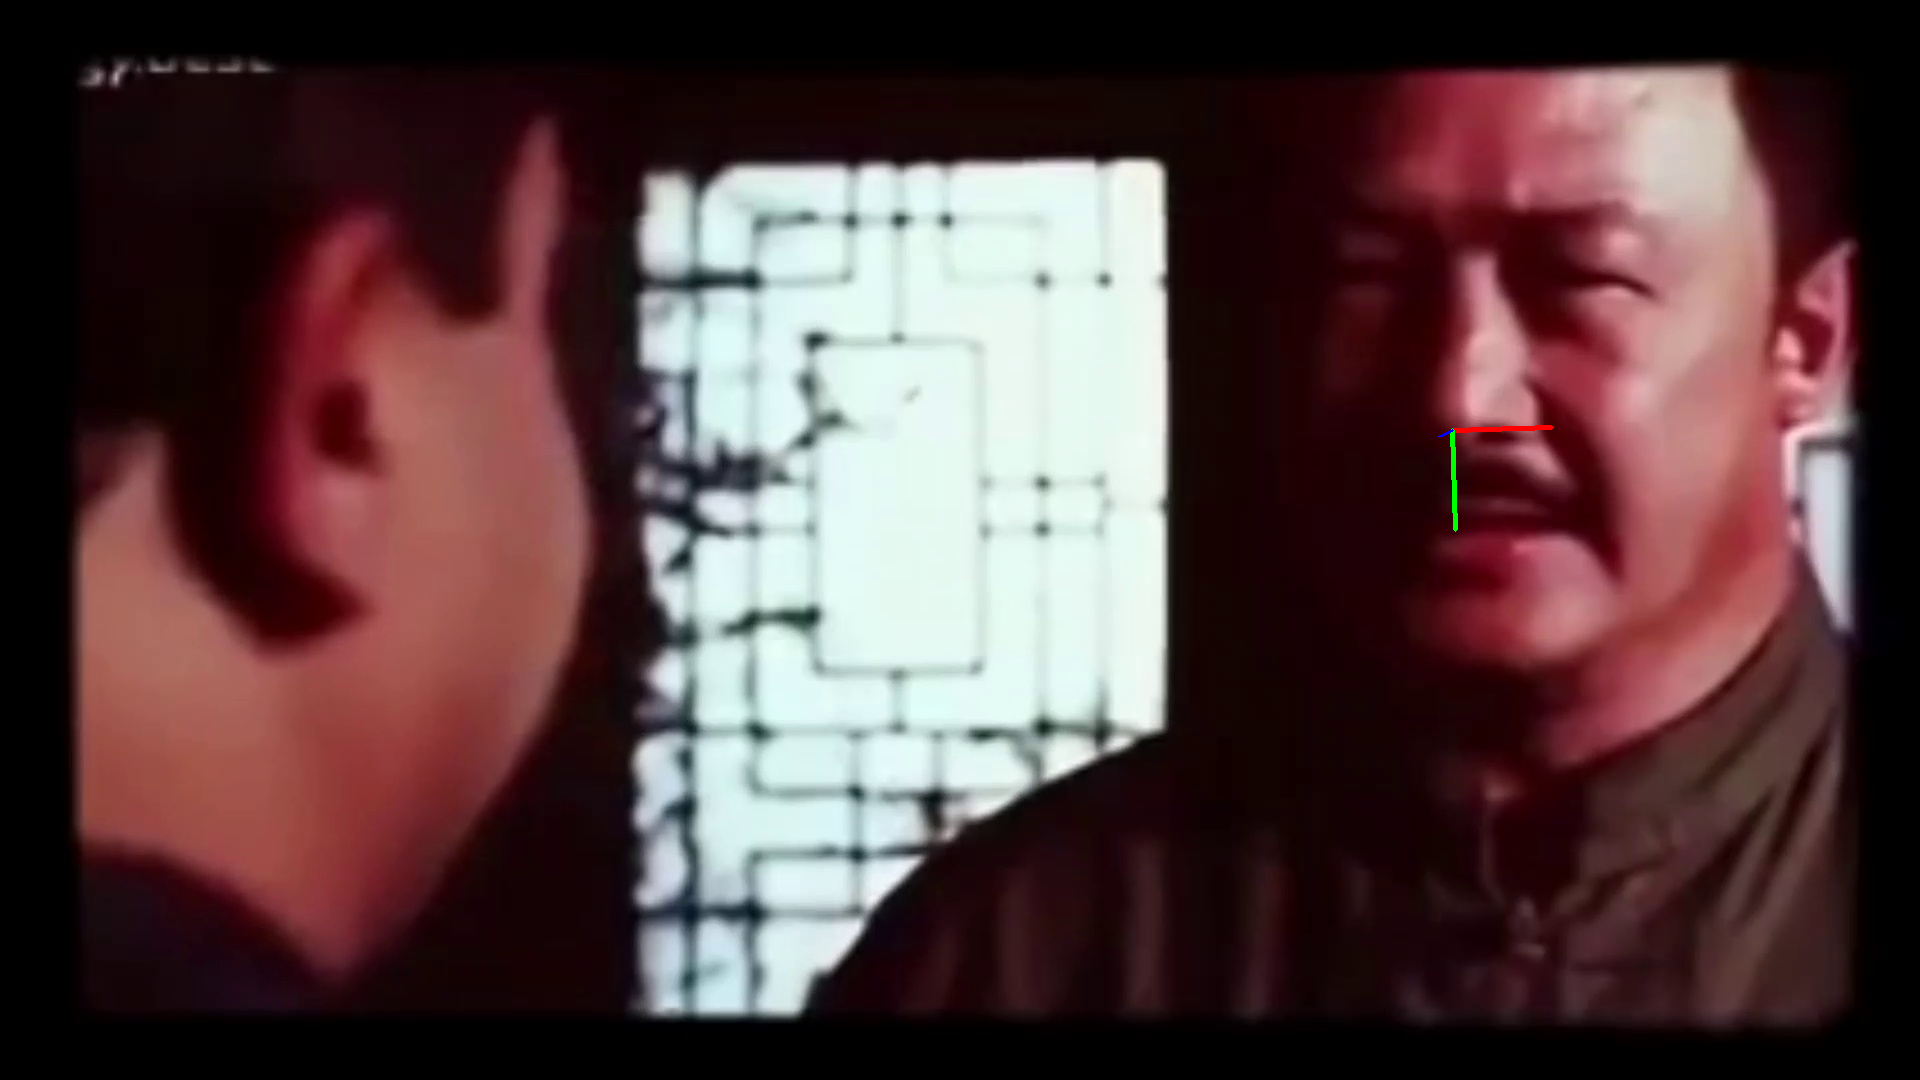

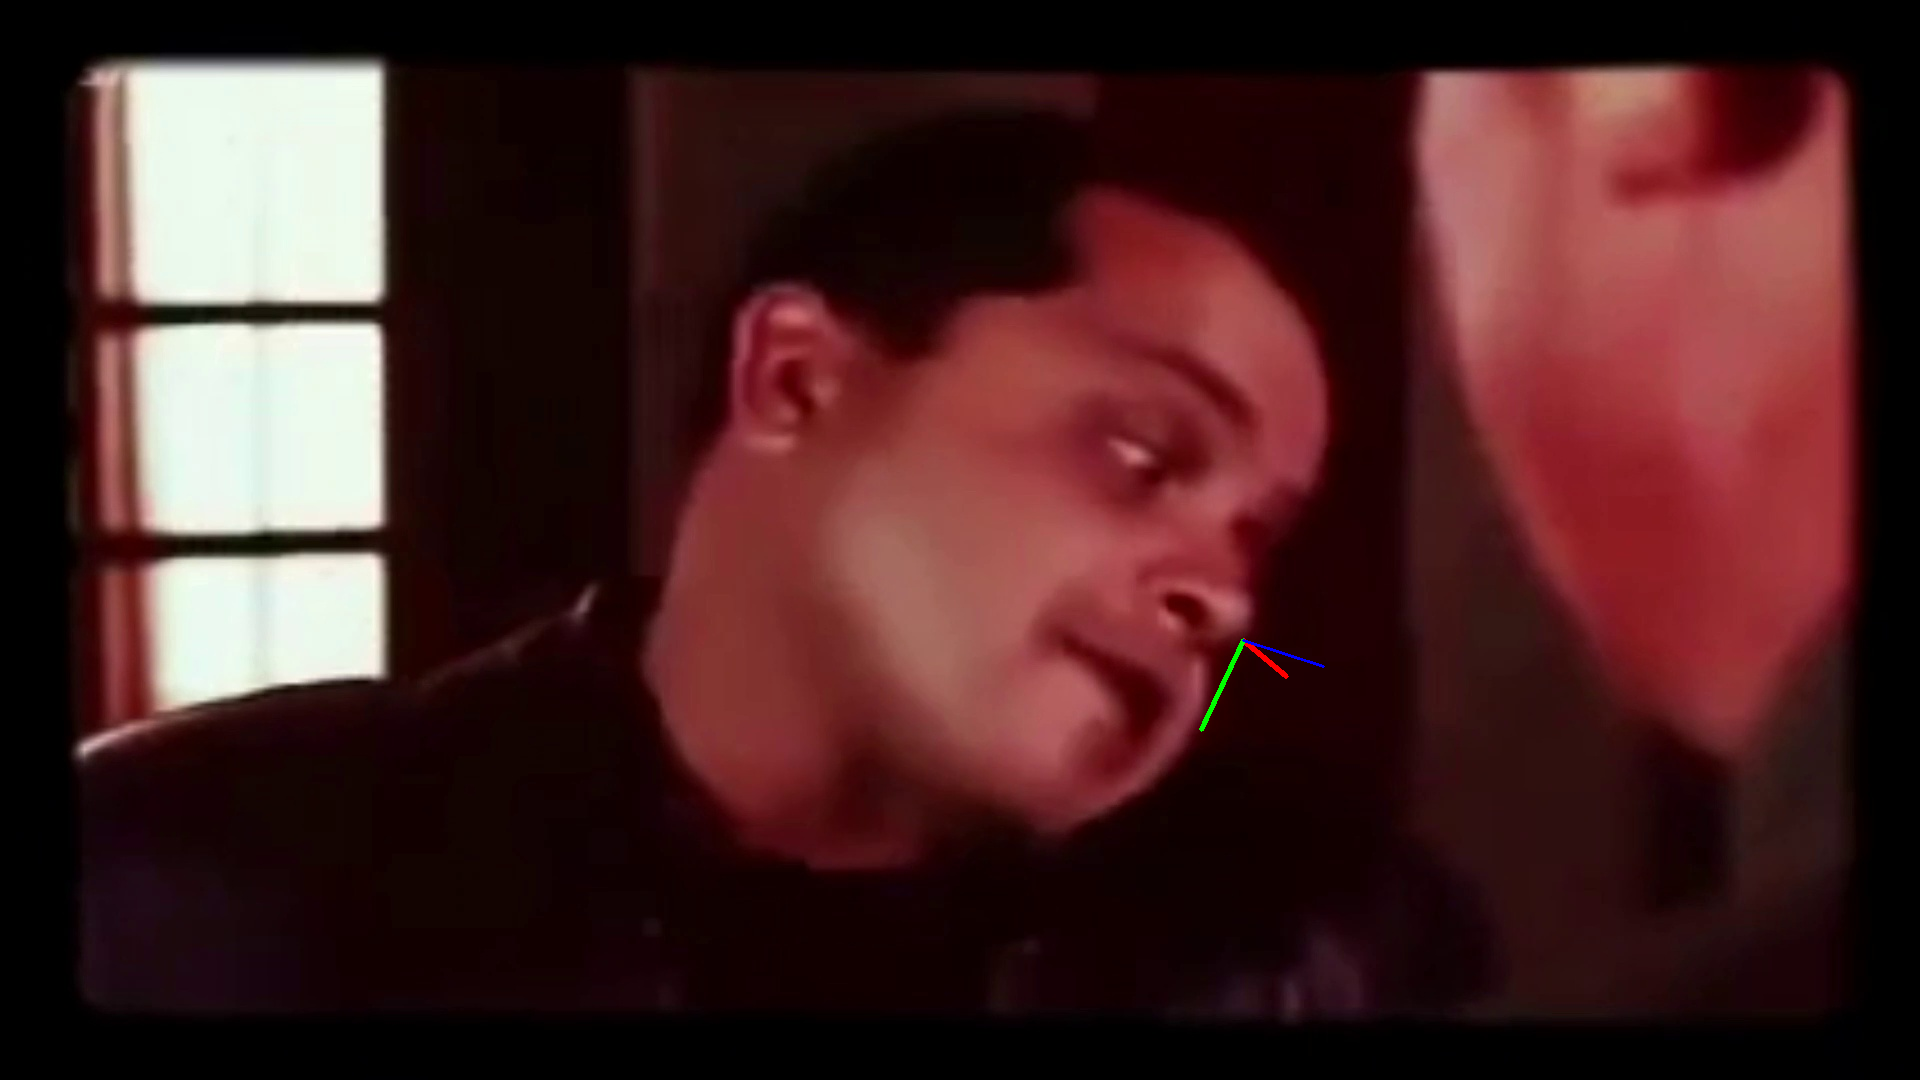

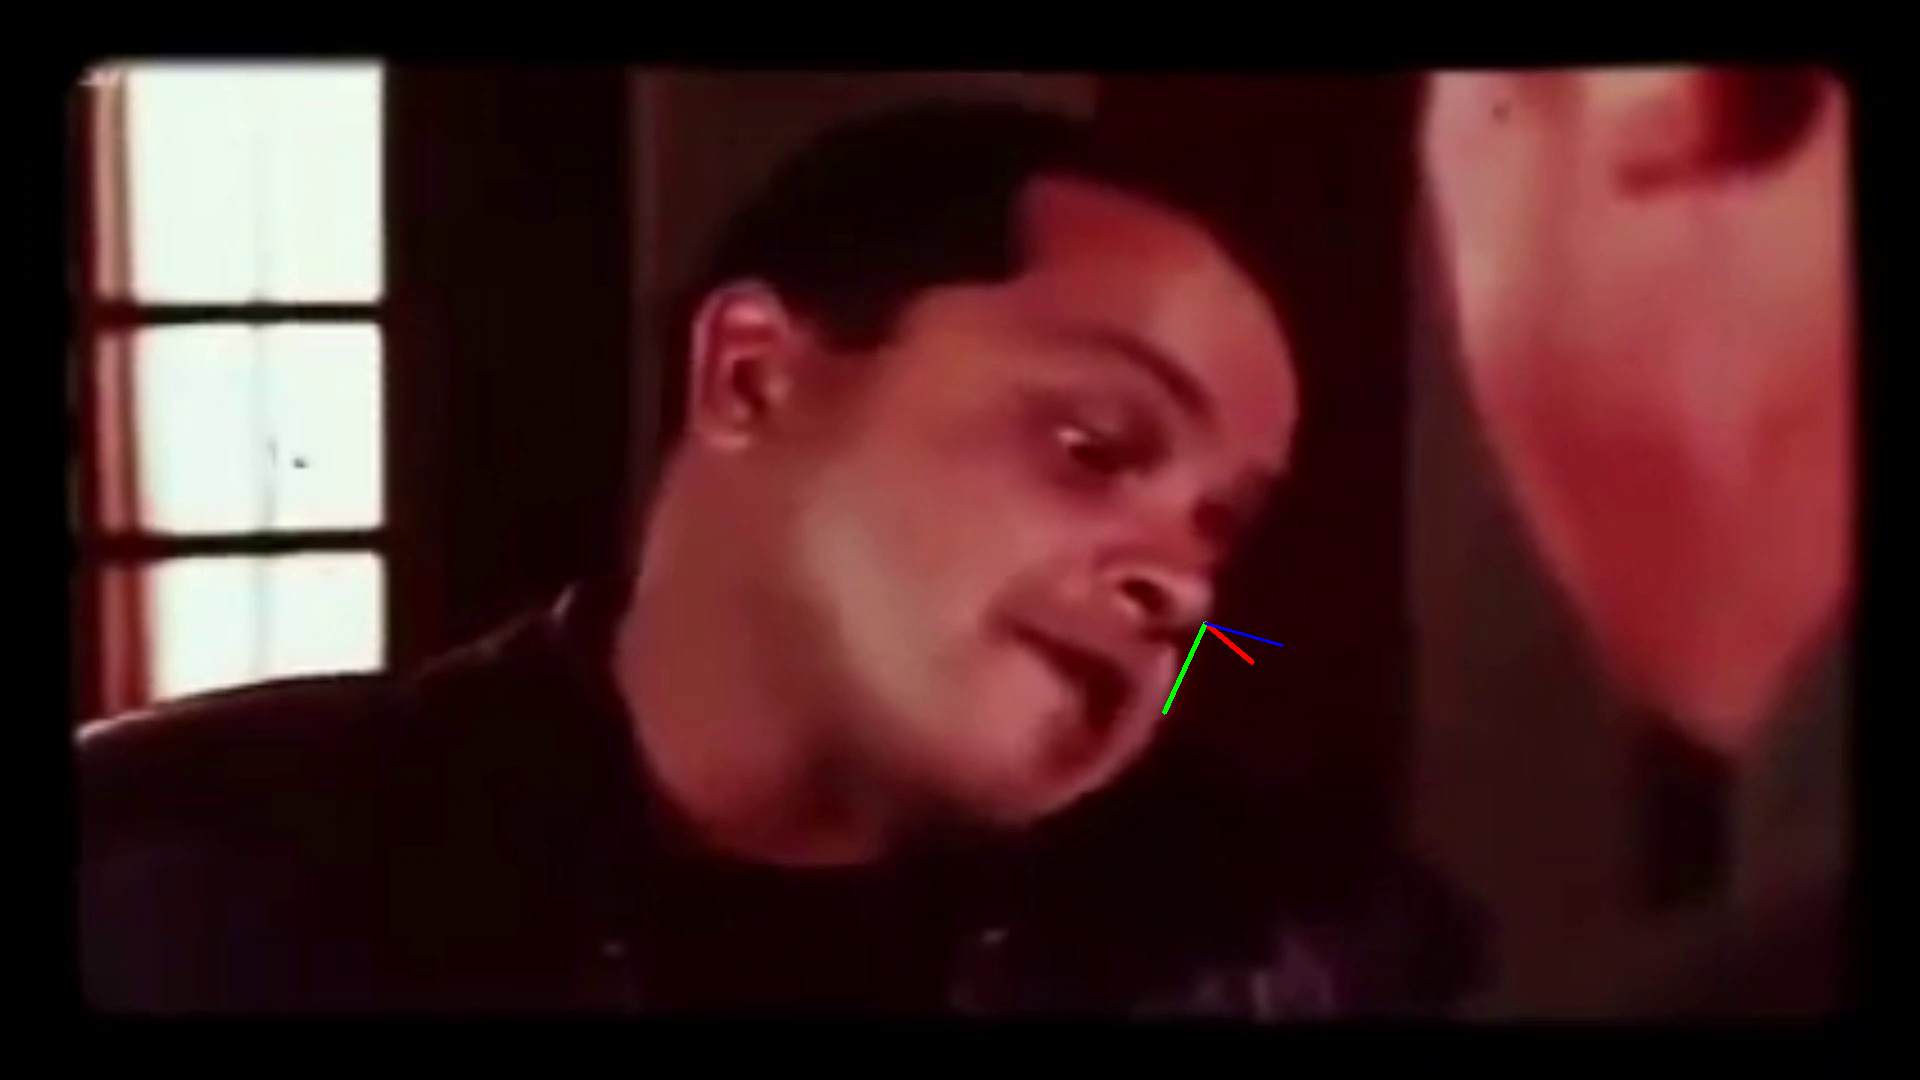

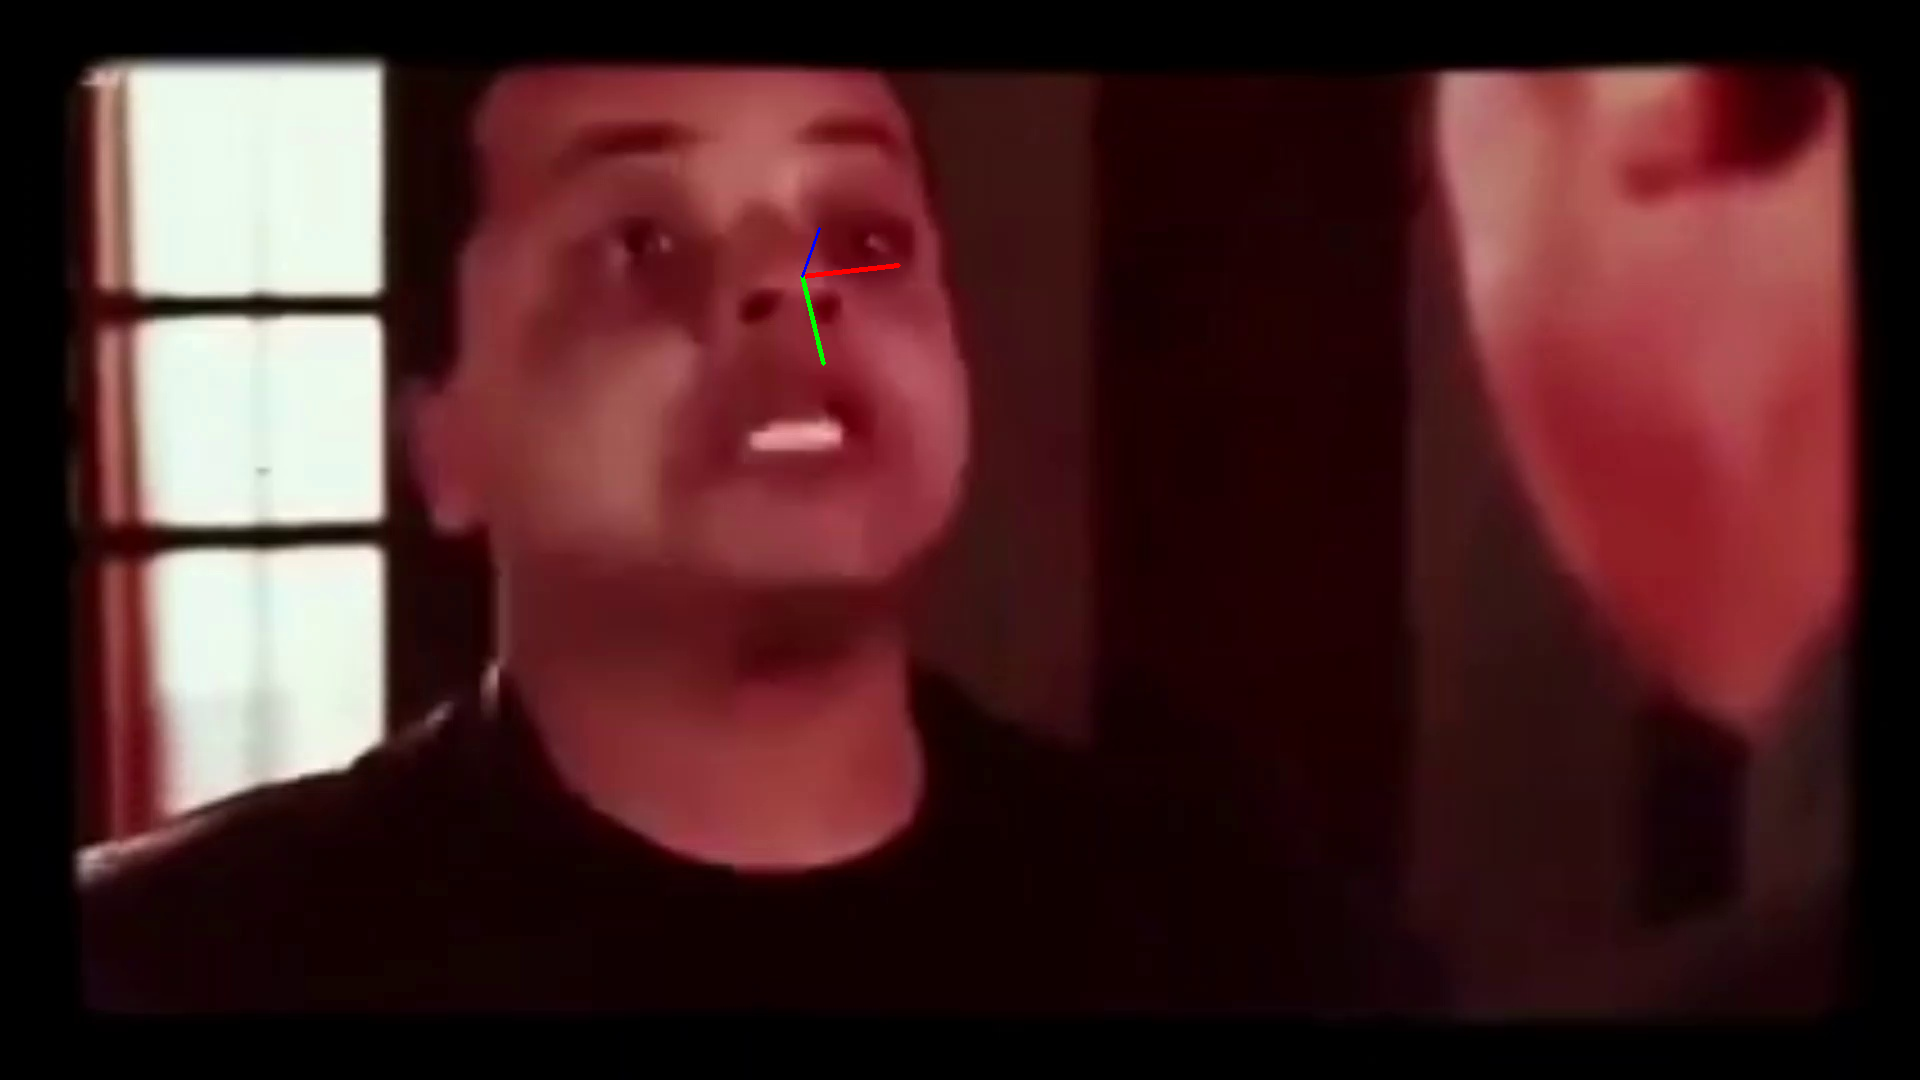

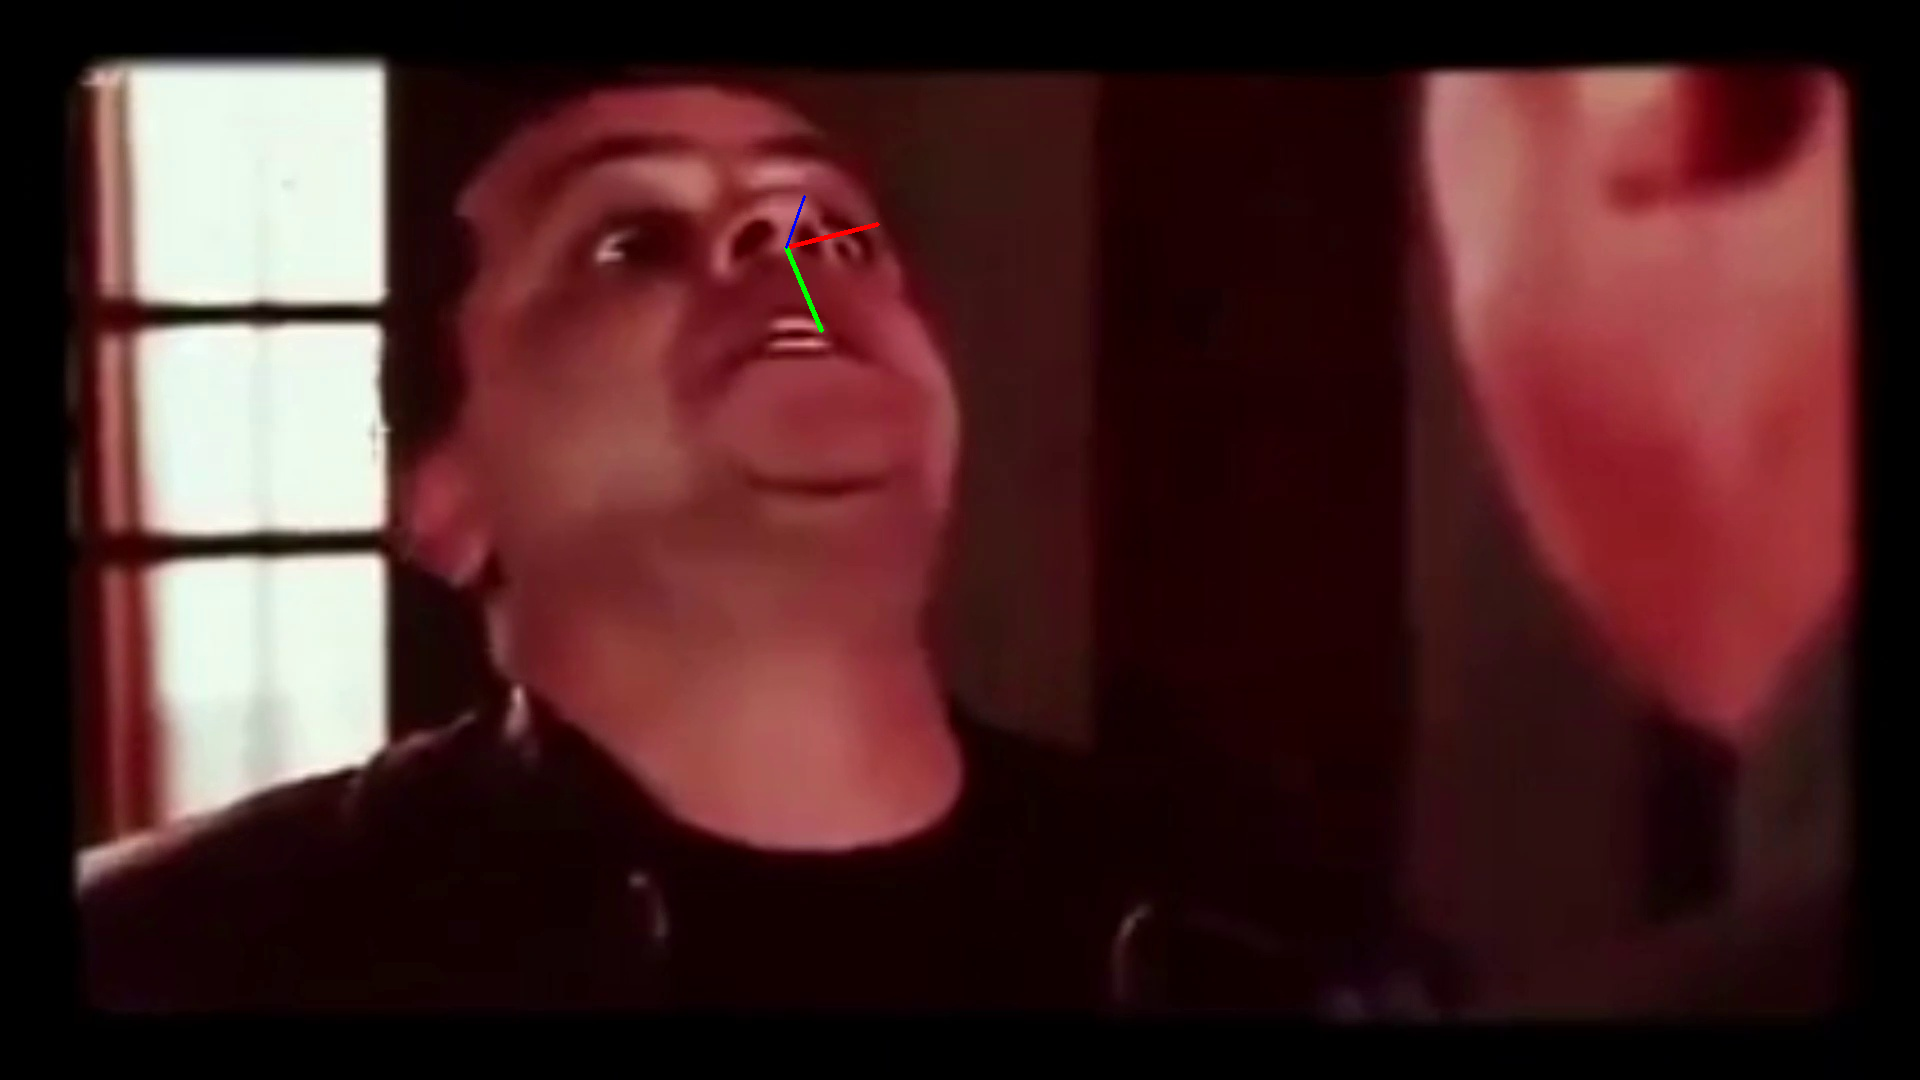

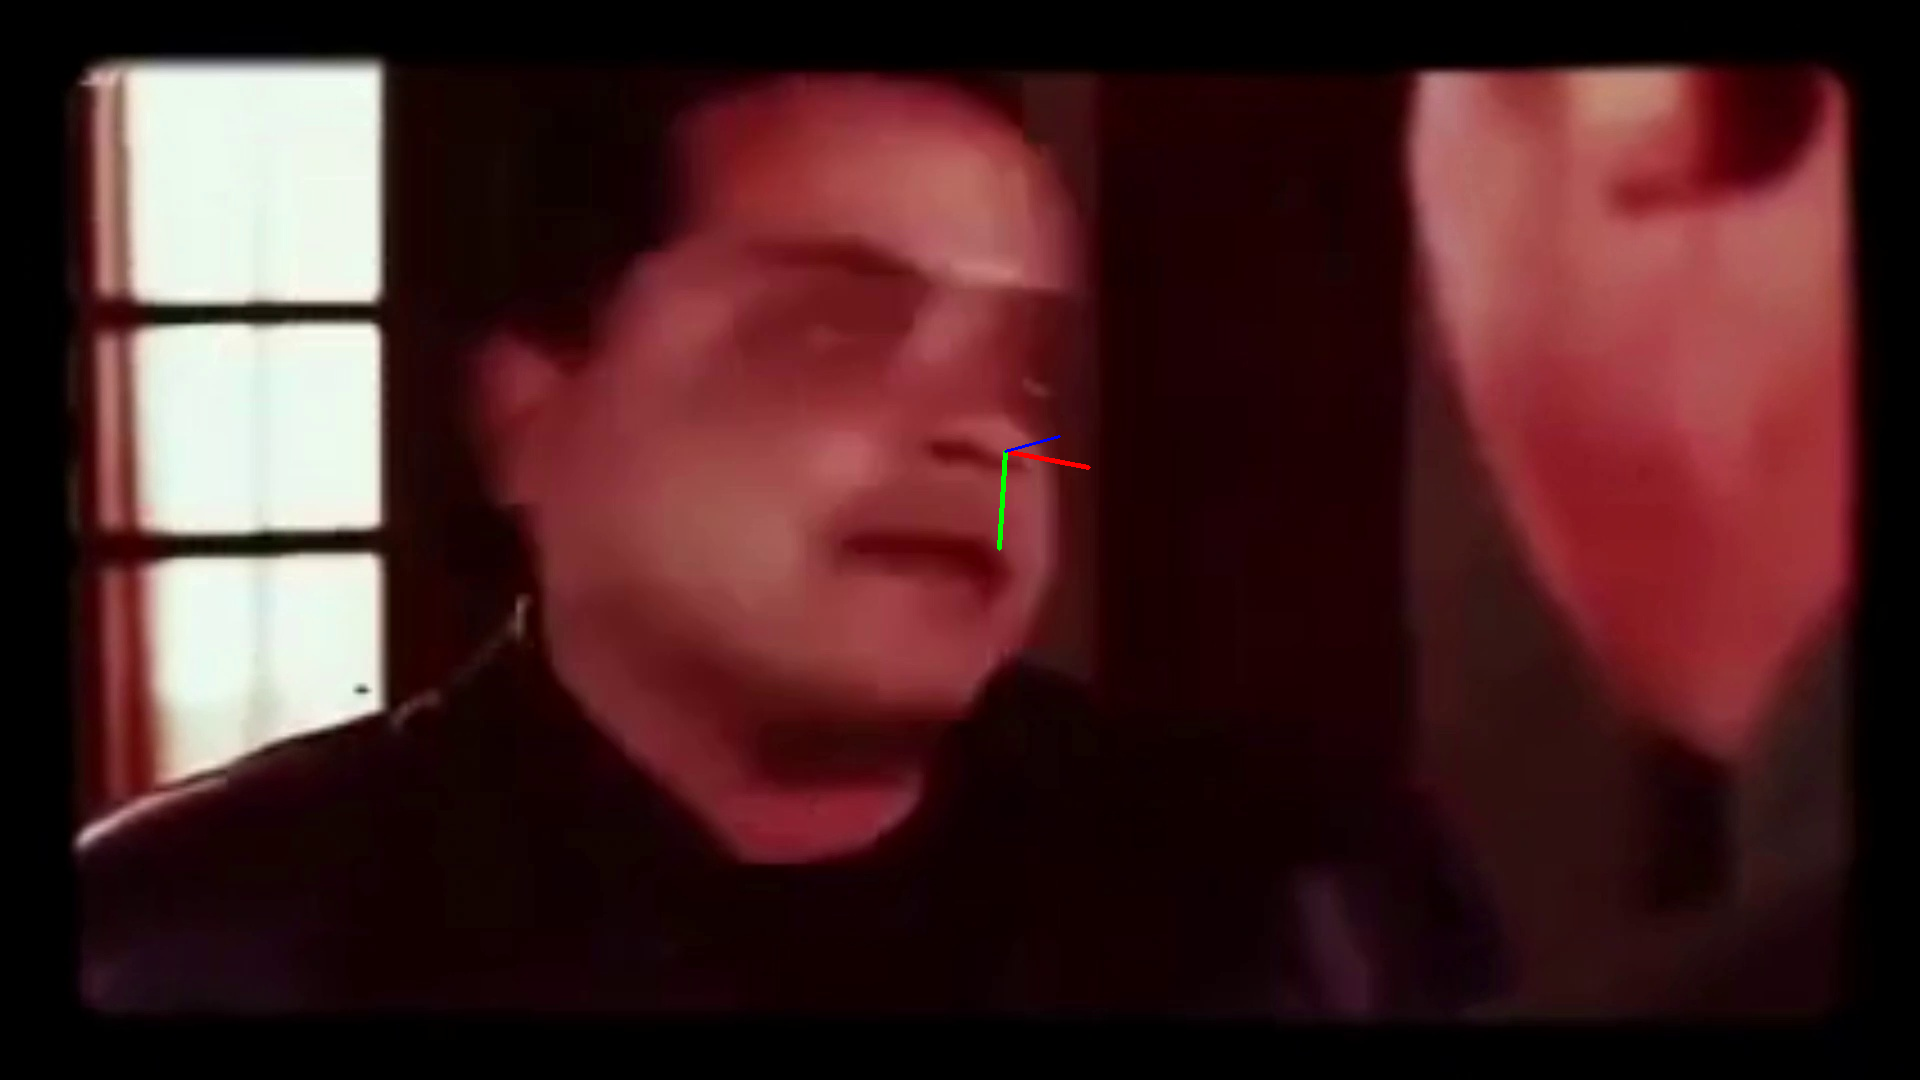

In [ ]:
i=0
out_vid=[]
for imj in os.listdir('/content/sample_data/Fr'):

  image = cv2.imread('/content/sample_data/Fr/'+imj)
  
  image1= draw_axis(image,vpitch[i],vyaw[i],vroll[i],originx[i],originy[i])
  cv2_imshow(image1)
  out_vid.append(image1)

  #cv2.imwrite("/content/sample_data/outp/out%d.jpg"%i,image1)
  i+=1
  #save video
vid=cv2.VideoWriter('/content/hinidy.avi',cv2.VideoWriter_fourcc(*'DIVX'))

for j in range(len(out_vid)):
  vid.write(out_vid[i])
vid.release()



In [60]:
def test_imj(path):
        faceModule = mediapipe.solutions.face_mesh
        lfeatures=[]
        with faceModule.FaceMesh(static_image_mode=True) as faces:
        # loading the image
          image = cv2.imread(path)
          # processing the face to extract the landmark points (468 point) for each x,y,z
          results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
         
          
          if results.multi_face_landmarks != None: 
            # looping over the faces in the image
            for face in results.multi_face_landmarks:
                for landmark in face.landmark:
                    x = landmark.x
                    y = landmark.y
                    
                    # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                    shape = image.shape 
                    relative_x = int(x * shape[1])
                    relative_y = int(y * shape[0])
                    lfeatures.extend([relative_x,relative_y])
                    
                
        return lfeatures,image

In [89]:
#transform imj
features,image=test_imj('/content/mickey.jpg')
features=pd.DataFrame(features).T
f=features.copy()
origx=f[2]
origy=f[3]
print(origx)
print(origy)


0    242
Name: 2, dtype: int64
0    190
Name: 3, dtype: int64


Test image

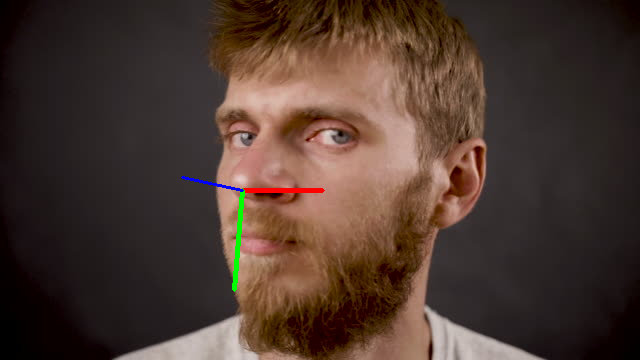

In [88]:
c_features=centeralize_imj(features)
imj_transf=standarize_imj(c_features)
pitch=pitch_sv.predict(imj_transf)
yaw=yaw_sv.predict(imj_transf)
roll=roll_sv.predict(imj_transf)

cv2_imshow(draw_axis(image,pitch,yaw,roll,242,190))
